
# Prognozowanie, ale nie pogody

### prognozowanie zapotrzebowania na energię elektryczną w mieszkaniu Stakeholder: elektrownia starająca się ustalić kiedy możliwe będzie przeprowadzenie napraw z uwagi na niższe zużycie energii

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsforecast.models import ARIMA
from statsmodels.tsa.stattools import adfuller

c:\Users\Wojciech\anaconda3\envs\python_intro\Lib\site-packages\statsforecast\core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv("../data/household_power_consumption.csv", sep=";")

C:\Users\Wojciech\AppData\Local\Temp\ipykernel_2508\3643888429.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/household_power_consumption.csv", sep=";")


In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [7]:
rows_with_questionmark_insteed_of_nan = df[df.applymap(lambda x: x == '?').any(axis=1)]

C:\Users\Wojciech\AppData\Local\Temp\ipykernel_2508\2988244428.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rows_with_questionmark_insteed_of_nan = df[df.applymap(lambda x: x == '?').any(axis=1)]


In [8]:
df.drop(rows_with_questionmark_insteed_of_nan.index, inplace=True)

In [9]:
# df = df.replace('?', np.nan)
# df.isna().sum()

In [10]:
select_columns = ['Global_active_power', 'Global_reactive_power','Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[select_columns] = df[select_columns].astype(float)
df["DateTime"] = pd.to_datetime(df["Date"] + " "+ df["Time"])
df = df.drop(['Date', 'Time'], axis=1)

C:\Users\Wojciech\AppData\Local\Temp\ipykernel_2508\3910187030.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DateTime"] = pd.to_datetime(df["Date"] + " "+ df["Time"])


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   DateTime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 140.7 MB


In [12]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2049280
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,2008-12-02 00:59:44.397740544
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2006-12-16 17:24:00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-10 05:37:45
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2008-11-30 01:22:30
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2009-11-23 20:31:15
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2010-11-26 21:02:00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,NaN


In [13]:
df = df[df['DateTime'].dt.date != pd.to_datetime('2006-12-16').date()]

In [14]:
df['Global_used_power'] = df['Global_active_power'] + df['Global_reactive_power']

In [15]:
df = df.drop(['Global_active_power', 'Global_reactive_power'], axis=1)

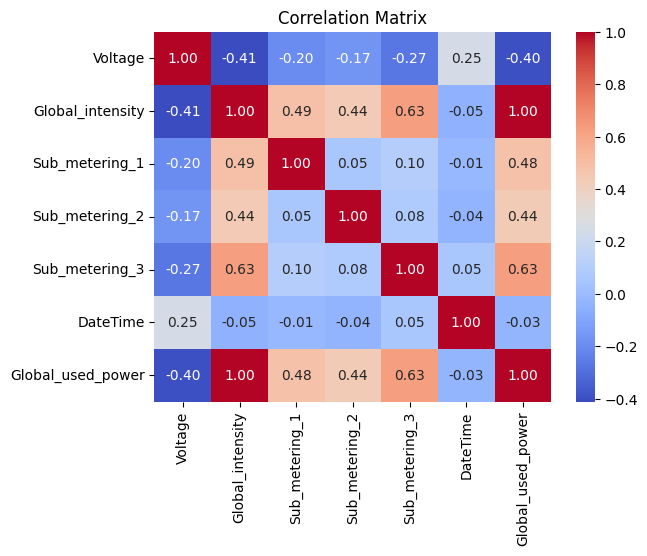

In [16]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [17]:
df.set_index('DateTime', inplace=True)
df_hour_sum = df.resample('H').sum()

In [18]:
df_hour_sum

,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_used_power
DateTime,,,,,,
2006-12-17 00:00:00,14457.71,487.6,0.0,28.0,0.0,119.094
2006-12-17 01:00:00,14426.90,854.8,0.0,1514.0,0.0,209.180
2006-12-17 02:00:00,14749.12,412.2,0.0,34.0,0.0,99.930
2006-12-17 03:00:00,14670.81,432.4,0.0,46.0,0.0,104.504
2006-12-17 04:00:00,14631.33,560.0,0.0,34.0,533.0,138.554
...,...,...,...,...,...,...
2010-11-26 17:00:00,14224.18,433.0,0.0,0.0,772.0,107.238
2010-11-26 18:00:00,14251.91,397.2,0.0,0.0,0.0,97.630
2010-11-26 19:00:00,14204.46,423.4,0.0,4.0,0.0,103.162


In [19]:
df_hour_sum.describe()

,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_used_power
count,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000,34582.000000
mean,14269.121266,274.084605,66.483575,76.932653,382.575935,71.982718
std,1608.222122,226.013477,211.109095,250.166849,440.292202,55.453791
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14344.805000,89.400000,0.000000,0.000000,38.000000,27.000000
50%,14455.805000,200.400000,0.000000,19.000000,99.000000,54.163000
75%,14560.340000,393.800000,0.000000,39.000000,836.000000,101.852500
max,15114.120000,1703.000000,2902.000000,2786.000000,1293.000000,417.074000


In [20]:
df_hour_sum = df_hour_sum.query('Global_used_power != 0')

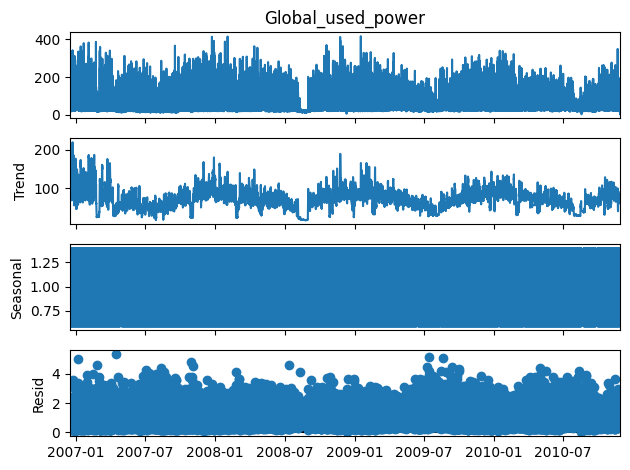

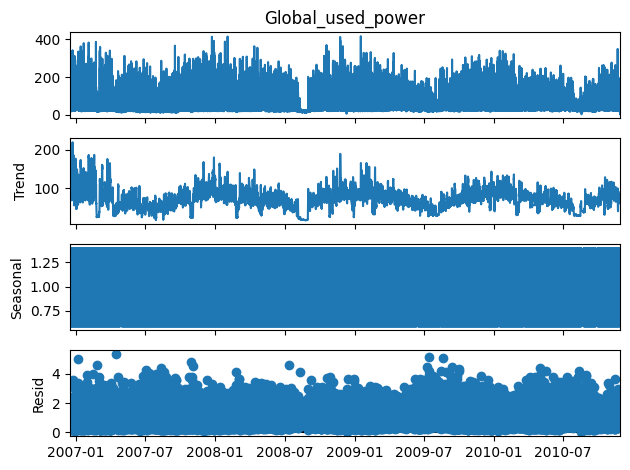

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_hour_sum["Global_used_power"], model='multiplicable', period=24)
res.plot()

In [22]:
res._seasonal[0:365]

DateTime
2006-12-17 00:00:00    0.983574
2006-12-17 01:00:00    0.907773
2006-12-17 02:00:00    0.850459
2006-12-17 03:00:00    0.851788
2006-12-17 04:00:00    0.945579
                         ...   
2007-01-01 00:00:00    0.983574
2007-01-01 01:00:00    0.907773
2007-01-01 02:00:00    0.850459
2007-01-01 03:00:00    0.851788
2007-01-01 04:00:00    0.945579
Name: seasonal, Length: 365, dtype: float64

In [23]:
res = adfuller(df_hour_sum["Global_used_power"])
p_value = res[1]
if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy zerowej ==> Dane mają pewną zalenosc czasowa i nie moga byc uznane za stacjonarne")
else:
    print("Dane sa stacjonarne")

Dane sa stacjonarne


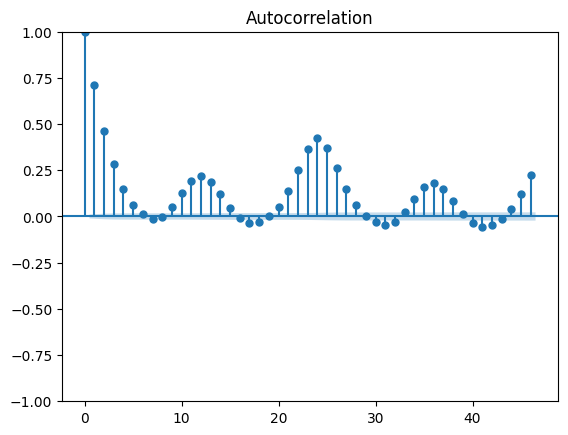

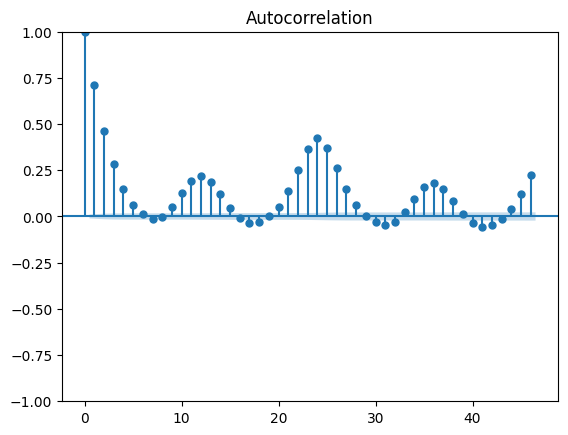

In [24]:
plot_acf(df_hour_sum["Global_used_power"])

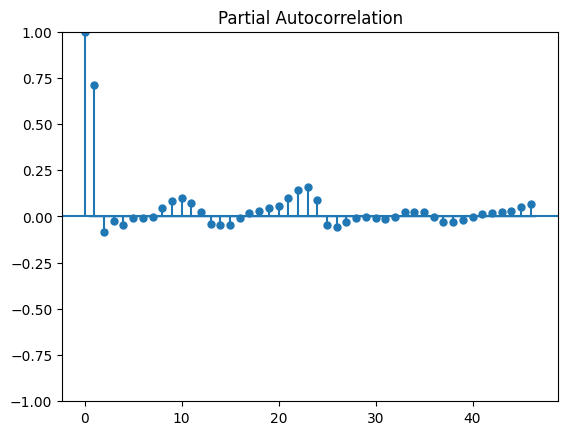

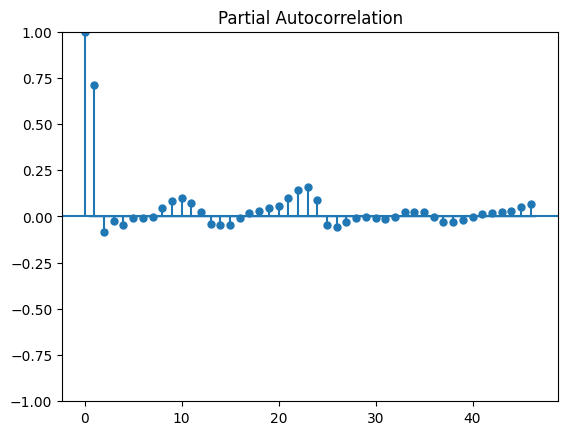

In [25]:
plot_pacf(df_hour_sum["Global_used_power"])

In [26]:
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta  

def plot_fitted_vs_original_exp(dataframe: pd.DataFrame, date_col_name: str, original_log_col_name: str, fitted_log_col_name: str):
    """
    Plots time serieses with original and fitted series
        Parameters:
            dataframe (pd.DataFrame): df with fitted and original values
            date_col_name (str): name of date index
            original_log_col_name (str): name of logged original values
            fitted_log_col_name (str): name of logged fitted values
        Returns:
            Plotly chart
    """
    fig = go.Figure()
    fig.add_scatter(x=dataframe[date_col_name], y=np.exp(dataframe[original_log_col_name]), mode='lines', name = 'REAL', line=dict(color='blue'))
    fig.add_scatter(x=dataframe[date_col_name], y=np.exp(dataframe[fitted_log_col_name]), mode='lines', name = 'FITTED', line=dict(color='gray'))
    fig.update_traces(line_width = 3, fillcolor = 'white')
    fig.update_layout(title = "REAL VS FITTED")
    fig.show()

  
def make_prediction_n_steps_ahead(model, orig_df:pd.DataFrame, date_col_name: str, forecast_steps: int, model_family: str):
    """
    Creates fcst_df for defined number of steps ahead
        Parameters:
            model: TS model
            orig_df (pd.DataFrame): original df
            date_col_name (str): name of date index
            forecast_steps (int): number of steps ahead to fcst
            model_family (str): ARIMA or ETS
        Returns:
            Dataframe with columns date_col_name and forecast
    """
    if model_family == "ARIMA":
        forecast = model.predict(h=forecast_steps)["mean"]
    elif model_family == "ETS":
        forecast = model.predict(params = model.params, start = orig_df.shape[0], end = orig_df.shape[0]+forecast_steps-1)

    forecast_dates = [orig_df[date_col_name].iloc[-1] + relativedelta(months=i+1) for i in range(forecast_steps)]
    forecast_df = pd.DataFrame({date_col_name: forecast_dates, 'forecast': forecast})
    return forecast_df


def plot_forecast(orig_dataframe: pd.DataFrame, fcst_dataframe: pd.DataFrame, date_col_name: str, original_log_col_name: str, fitted_log_col_name: str, fcst_log_col_name: str):
    """
    Creates df for forecast, makes forecast and then plots fcst vs 
        Parameters:
            dataframe (pd.DataFrame): df with fitted and original values
            data_col_name (str): name of date index
            original_log_col_name (str): name of logged original values
            fitted_log_col_name (str): name of logged fitted values
            fcst_log_col_name (str): name of fcst logged values
        Returns:
            Plotly chart
    """
    fig = go.Figure()
    fig.add_scatter(x=orig_dataframe[date_col_name], y=np.exp(orig_dataframe[original_log_col_name]), mode='lines', name = 'REAL', line=dict(color='blue'))
    fig.add_scatter(x=orig_dataframe[date_col_name], y=np.exp(orig_dataframe[fitted_log_col_name]), mode='lines', name = 'FITTED', line=dict(color='gray'))
    fig.add_scatter(x=fcst_dataframe[date_col_name], y=np.exp(fcst_dataframe[fcst_log_col_name]), mode='lines', name = 'FORECAST', line=dict(color='yellow'))
    fig.update_traces(line_width = 3, fillcolor = 'white')
    fig.update_layout(title = "REAL VS FITTED VS FORECAST")
    fig.show()

In [27]:
# my_loop_df = pd.DataFrame(columns = ["sar", "sd", "sma", "aic"])
# for sar in [0,1,2]:
#     for sma in [0,1,2]:
#         for sd in [0,1,2]:
#             model = ARIMA(order = (2, 1, 1), season_length=365, seasonal_order=(sar,sd,sma))
#             model.fit(df_hour_sum["Global_used_power"].values)
#             my_loop_df.loc[len(my_loop_df)] = [sar, sd, sma, model.model_["aic"]]


In [28]:
# my_loop_df.sort_values(by="aic")

In [29]:
# Modeling
model = ARIMA(order = (2, 1, 1), season_length=365, seasonal_order=(0,1,1))
res = model.fit(y = df_hour_sum["Global_used_power"].values)


# Post processing
df_hour_sum["FITTED"] = df_hour_sum["Global_used_power"].values - res.model_["residuals"]
df_hour_sum["RESID"] = res.model_["residuals"]

# Plot results
plot_fitted_vs_original_exp(df_hour_sum, "DateTime", "Global_used_power", "FITTED")

# Plot residuals
fig = go.Figure()
fig.add_scatter(x = df_hour_sum['DateTime'], y = df_hour_sum['RESID'], mode = 'lines', name = 'REAL', line = dict(color='blue'))
fig.update_layout(title = "RESIDUALS")
fig.show()

# Make forecast
forecast_df = make_prediction_n_steps_ahead(model, df_hour_sum, date_col_name = "DateTime", forecast_steps = 365, model_family = "ARIMA")

# Plot results
plot_forecast(df_hour_sum, forecast_df, "DateTime", "Global_used_power", "FITTED", "forecast")

print("AIC: ", model.model_["aic"])

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Modeling
model = ExponentialSmoothing(df_hour_sum["Global_used_power"], trend = 'add', seasonal = 'add', seasonal_periods = 12)
res = model.fit()

# Post processing
df_hour_sum["FITTED"] = df_hour_sum["Global_used_power"].values - res.resid
df_hour_sum["RESID"] = res.resid

# Plot results
plot_fitted_vs_original_exp(df_hour_sum, "DateTime", "Global_used_power", "FITTED")

# Plot residuals
fig = go.Figure()
fig.add_scatter(x = df_hour_sum['DateTime'], y = df_hour_sum['RESID'], mode = 'lines', name = 'REAL', line = dict(color='blue'))
fig.update_layout(title = "RESIDUALS")
fig.show()

# Make forecast
forecast_df = make_prediction_n_steps_ahead(model, df_hour_sum, date_col_name = "DateTime", forecast_steps = 12, model_family = "ETS")

# Plot results
plot_forecast(df_hour_sum, forecast_df, "DateTime", "Global_used_power", "FITTED", "forecast")